## IMPORTS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns

from metrics.dataquality import calculate_data_quality_metrics
from metrics.dataquality import calculate_average_metrics
from metrics.overallscore import calculate_overall_score
from metrics.overallscore import calculate_overall_score_mom
from metrics.feature_calculations import calculate_unique_meter_count
from metrics.feature_calculations import calculate_metrics_by_month
from metrics.feature_calculations import calculate_blank_metrics
from metrics.dataquality_data import calculate_validity
from metrics.dataquality_data import calculate_integrity

## READING DATA

In [2]:
data = pd.read_csv(os.path.expanduser("~/OneDrive/dev/data/yedc/dqm/caims_data_may.csv"), low_memory=False)

In [3]:
data_no_dc = data[data['is_on_board'] != 'Direct Connection']

In [5]:
column_mapping = {
    'slrn': 'SLRN',
    'ac_no': 'Account Number',
    'meter_number': 'Meter Number',
    'meter_status': 'Meter Status',
    'meter_slrn': 'Meter SLRN',
    'phone_number': 'Phone Number',
    'email': 'Email',
    'date': 'Date',
    'first_captured_username': 'First Captured Username',
    'updated_username': 'Updated Username'
}
data_x = data_no_dc.copy()
data_x.rename(columns=column_mapping, inplace=True)

In [6]:
filtered_data_yedc = data_x

In [7]:
df = filtered_data_yedc.copy()

## METRICS

In [8]:
metrics_list = []

# Calculate metrics for each key field
key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Phone Number', 'Email']

for field_name in key_fields:
    if field_name in df.columns:
        if field_name in ['SLRN', 'Account Number', 'Meter Number']:
            metrics = calculate_data_quality_metrics(df, field_name, 'YEDCBD', 13)
        elif field_name == 'Phone Number':
            metrics = calculate_data_quality_metrics(df, field_name, 'YEDCBD', 13)
        elif field_name == 'Email':
            metrics = calculate_data_quality_metrics(df, field_name, 'YEDCBD', 13)
        
        metrics_list.append(metrics)

# Calculate average completeness, validity, and integrity
average_completeness = calculate_average_metrics(metrics_list, 'Completeness')
average_validity = calculate_average_metrics(metrics_list, 'Validity')
average_integrity = calculate_average_metrics(metrics_list, 'Integrity')

# Calculate overall score using the overall_score function
overall_score = calculate_overall_score(average_completeness, average_validity, average_integrity)

total_caims_data = df['SLRN'].count()
print(f'\nSample Data: {total_caims_data:,}')

# Display the results
print("\nQuality Metrics for Each Field:")
for field_name in key_fields:
    if field_name in df.columns:
        print(f"\nMetrics for {field_name}:")
        print(f"Completeness: {metrics_list[key_fields.index(field_name)]['Completeness']:.2f}%")
        print(f"Validity: {metrics_list[key_fields.index(field_name)]['Validity']:.2f}%")
        print(f"Integrity: {metrics_list[key_fields.index(field_name)]['Integrity']:.2f}%")
        
        # Calculate and print the overall score for each field
        field_overall_score = calculate_overall_score(
            metrics_list[key_fields.index(field_name)]['Completeness'],
            metrics_list[key_fields.index(field_name)]['Validity'],
            metrics_list[key_fields.index(field_name)]['Integrity']
        )
        print(f"Overall Score: {field_overall_score:.2f}")

print("\nQuality Metrics - Average and Overall Score:")
print(f"Average Completeness: {average_completeness:.2f}%")
print(f"Average Validity: {average_validity:.2f}%")
print(f"Average Integrity: {average_integrity:.2f}%")
print(f"Overall Score: {overall_score:.2f}")



Sample Data: 16,846

Quality Metrics for Each Field:

Metrics for SLRN:
Completeness: 100.00%
Validity: 99.99%
Integrity: 99.98%
Overall Score: 99.99

Metrics for Account Number:
Completeness: 99.83%
Validity: 99.80%
Integrity: 80.52%
Overall Score: 93.38

Metrics for Meter Number:
Completeness: 80.52%
Validity: 80.51%
Integrity: 80.51%
Overall Score: 80.51

Metrics for Phone Number:
Completeness: 81.21%
Validity: 81.21%
Integrity: 65.36%
Overall Score: 75.93

Metrics for Email:
Completeness: 32.70%
Validity: 1.22%
Integrity: 1.07%
Overall Score: 11.67

Quality Metrics - Average and Overall Score:
Average Completeness: 78.85%
Average Validity: 72.55%
Average Integrity: 65.49%
Overall Score: 72.30


In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year Month'] = df['Date'].dt.to_period('M')
df['date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
df["date"] = df.date.astype(str)
df["year_month"] = df.date.str[0:7]
df["year_month"] = df.year_month.str.replace('-', '')
df["year_month"] = df.year_month.apply(lambda x: int(x) if str(x).isdigit() else 0)

In [10]:
# Compute unique meter count
unique_meter_count_df = calculate_unique_meter_count(df, 'Year Month', 'Meter Number')


# Calculate overall data quality score on a monthly basis and link it back to the DataFrame
mom_overall_score = calculate_overall_score_mom(df)
mom_overall_score_fil = mom_overall_score[mom_overall_score['year_month'] >= 202305]
mom_overall_score_fil = mom_overall_score_fil[['Year Month', 'Overall Score', 'year_month']]
mom_overall_score_fil = mom_overall_score_fil.sort_values(by='year_month', ascending=True)
mom_overall_score_fil = mom_overall_score_fil.drop_duplicates(subset=['Year Month'])

mom_overall_score_fil = pd.merge(mom_overall_score_fil, unique_meter_count_df, on='Year Month', how='left')

In [11]:
key_fields = ['Account Number', 'Phone Number', 'Email']

blank_metrics_df = calculate_blank_metrics(df, key_fields)

blank_metrics_df


,Year Month,Field,Total Records,Blanks,Blank Percentage
0,2024-01,Account Number,313,5,1.597444
1,2024-01,Phone Number,313,4,1.277955
2,2024-01,Email,313,8,2.555911
3,2024-02,Account Number,968,0,0.000000
4,2024-02,Phone Number,968,52,5.371901
5,2024-02,Email,968,266,27.479339
6,2024-03,Account Number,5586,10,0.179019
7,2024-03,Phone Number,5586,654,11.707841
8,2024-03,Email,5586,3956,70.819907
9,2024-04,Account Number,6173,5,0.080998


C:\Users\Moshood\AppData\Local\Temp\ipykernel_30388\2999179704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metrics_df.loc[:, 'Year Month'] = filtered_metrics_df['Year Month'].astype(str)


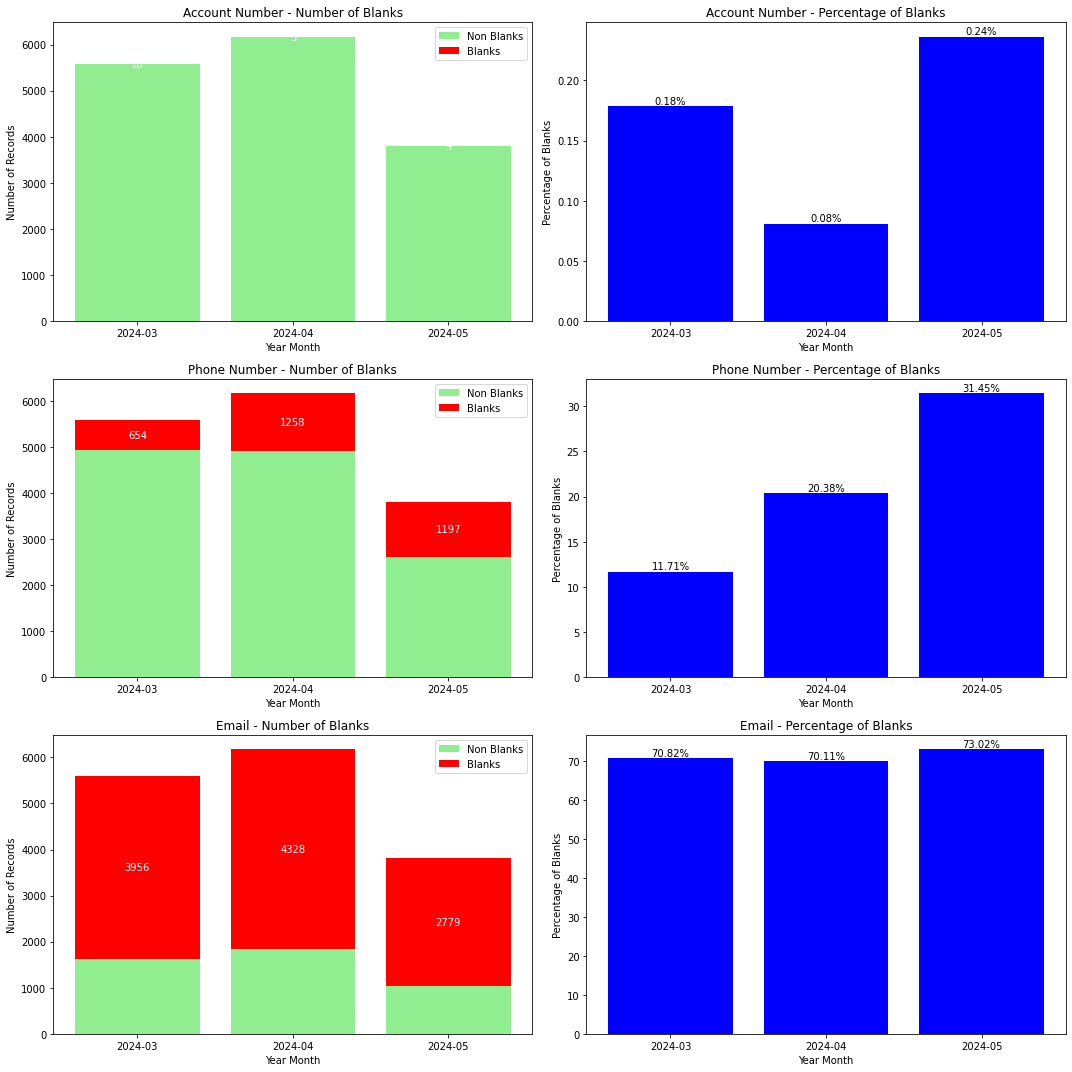

In [12]:
# Filter the last 3 months of data
plot_data = blank_metrics_df.copy()
last_3_months = plot_data['Year Month'].unique()[-3:]
filtered_metrics_df = plot_data[plot_data['Year Month'].isin(last_3_months)]

# Convert 'Year Month' to string for plotting
filtered_metrics_df.loc[:, 'Year Month'] = filtered_metrics_df['Year Month'].astype(str)

# Plotting the data
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

fields = ['Account Number', 'Phone Number', 'Email']
for i, field in enumerate(fields):
    field_data = filtered_metrics_df[filtered_metrics_df['Field'] == field]
    
    # Plot number of blanks as 100% stacked column chart
    total_records = field_data['Total Records']
    blanks = field_data['Blanks']
    non_blanks = total_records - blanks

    bars_non_blanks = axes[i, 0].bar(field_data['Year Month'], non_blanks, label='Non Blanks', color='lightgreen')
    bars_blanks = axes[i, 0].bar(field_data['Year Month'], blanks, bottom=non_blanks, label='Blanks', color='red')
    
    axes[i, 0].set_title(f'{field} - Number of Blanks')
    axes[i, 0].set_xlabel('Year Month')
    axes[i, 0].set_ylabel('Number of Records')
    axes[i, 0].legend()

    for bar in bars_blanks:
        height = bar.get_height()
        axes[i, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{int(height)}', ha='center', va='center', color='white')

    # Plot percentage of blanks
    axes[i, 1].bar(field_data['Year Month'], field_data['Blank Percentage'], color='blue')
    axes[i, 1].set_title(f'{field} - Percentage of Blanks')
    axes[i, 1].set_xlabel('Year Month')
    axes[i, 1].set_ylabel('Percentage of Blanks')
    for x, y in zip(field_data['Year Month'], field_data['Blank Percentage']):
        axes[i, 1].text(x, y, f'{y:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## MOM CHART

In [9]:
# # Plot overall data quality score on a MoM basis
# fig, ax1 = plt.subplots(figsize=(20, 10))

# # Plot the overall score on the primary y-axis
# ax1.plot(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Overall Score'].round(2), marker='o', linestyle='-', color='b', label='Overall Score')
# ax1.set_xlabel('Year Month')
# ax1.set_ylabel('Overall Score', color='b')
# ax1.tick_params('y', colors='b')

# # Text annotations
# for i, txt in enumerate(mom_overall_score_fil['Overall Score'].round(2)):
#     ax1.text(mom_overall_score_fil['Year Month'].astype(str).iloc[i], txt, f'{txt:.2f}', ha='center', va='bottom')

# # Secondary y-axis for the count of unique meter numbers
# ax2 = ax1.twinx()
# bars = ax2.bar(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Unique Meter Count'], alpha=0.6, color='red', label='Unique Meter Count')
# ax2.set_ylabel('Total Customers', color='r')
# ax2.tick_params('y', colors='r')

# # Add labels on the bar chart with MoM figures
# for bar in bars:
#     yval = bar.get_height()
#     ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', va='bottom', ha='center')

# # Show the plot
# plt.title('Overall Data Quality Score and Unique Customer Count (MoM)')
# plt.grid(True)
# plt.show()


In [10]:
# mom_overall_score_fil[['Year Month', 'Overall Score']].to_csv('data/exports/mom_overall_score_dec_2023.csv', index=False)

In [11]:
# mom_overall_score_fil

### CALCULATE METRICS BY MONTH

In [10]:
key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Phone Number', 'Email']

mom_data_quality_metrics = calculate_metrics_by_month(
    df, 
    key_fields, 
    bd_slrn='YEDCBD', 
    bdslrn_len=13, 
)

In [11]:
mom_data_quality_metrics

,Year Month,Key fields,Completeness,Validity,Integrity,Average Completeness,Average Validity,Average Integrity,Overall Score,Unique Meter Count
0,2024-01,SLRN,100.000000,99.680511,99.361022,96.549521,85.942492,80.447284,87.646432,275
1,2024-01,Account Number,98.402556,98.083067,88.178914,96.549521,85.942492,80.447284,87.646432,275
2,2024-01,Meter Number,88.178914,88.178914,88.178914,96.549521,85.942492,80.447284,87.646432,275
3,2024-01,Phone Number,98.722045,98.722045,86.900958,96.549521,85.942492,80.447284,87.646432,275
4,2024-01,Email,97.444089,45.047923,39.616613,96.549521,85.942492,80.447284,87.646432,275
5,2024-02,SLRN,100.000000,100.000000,100.000000,86.694215,73.181818,59.793388,73.223140,640
6,2024-02,Account Number,100.000000,99.793388,66.322314,86.694215,73.181818,59.793388,73.223140,640
7,2024-02,Meter Number,66.322314,66.322314,66.322314,86.694215,73.181818,59.793388,73.223140,640
8,2024-02,Phone Number,94.628099,94.628099,61.880165,86.694215,73.181818,59.793388,73.223140,640
9,2024-02,Email,72.520661,5.165289,4.442149,86.694215,73.181818,59.793388,73.223140,640


In [13]:
mom_overall_score_fil_two = mom_data_quality_metrics[['Year Month', 'Overall Score', 'Unique Meter Count']]

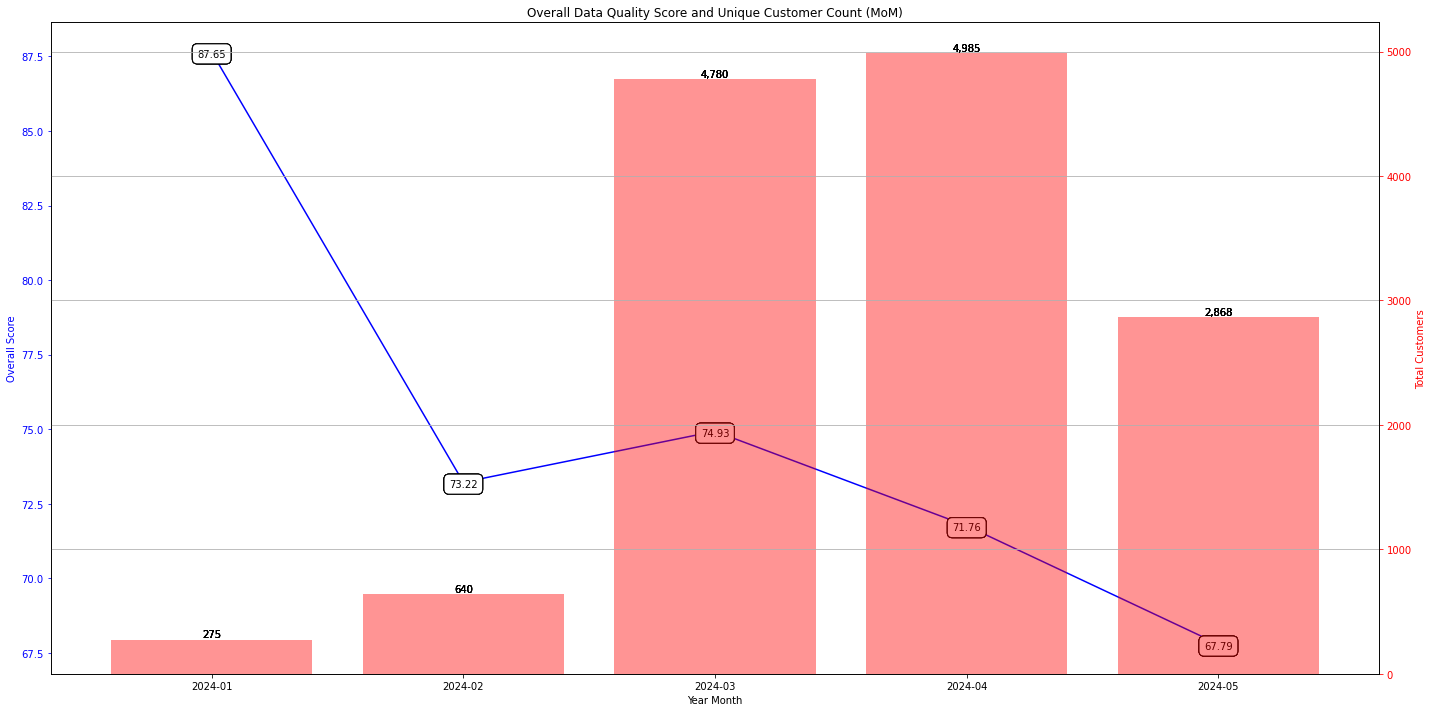

In [14]:
import matplotlib.pyplot as plt

# Plot overall data quality score on a MoM basis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the overall score on the primary y-axis
ax1.plot(mom_overall_score_fil_two['Year Month'].astype(str), mom_overall_score_fil_two['Overall Score'].round(2), marker='o', linestyle='-', color='b', label='Overall Score')
ax1.set_xlabel('Year Month')
ax1.set_ylabel('Overall Score', color='b')
ax1.tick_params('y', colors='b')

# Text annotations with adjusted positions
for i, (x, y) in enumerate(zip(mom_overall_score_fil_two['Year Month'].astype(str), mom_overall_score_fil_two['Overall Score'].round(2))):
    ax1.text(x, y - 0.23, f'{y:.2f}', ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'), zorder=10)

# Secondary y-axis for the count of unique meter numbers
ax2 = ax1.twinx()
bars = ax2.bar(mom_overall_score_fil_two['Year Month'].astype(str), mom_overall_score_fil_two['Unique Meter Count'], alpha=0.1, color='red', label='Unique Meter Count')
ax2.set_ylabel('Total Customers', color='r')
ax2.tick_params('y', colors='r')

# Add labels on the bar chart with MoM figures
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', va='bottom', ha='center')

# Show the plot
plt.title('Overall Data Quality Score and Unique Customer Count (MoM)')
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()


In [16]:
# mom_data_quality_metrics.to_csv('data/exports/mom_metrics.csv', index=False)

## DATA QUALITY DATA

In [15]:
fields_of_interest = ['SLRN', 'Account Number', 'Meter Number', 'Phone Number', 'Email']

results = {}

# Iterate through each field of interest
for field in fields_of_interest:
    # Calculate validity and integrity for the current field
    validity = calculate_validity(df, field, slrn_prefix='YEDCBD', slrn_length=13)
    integrity = calculate_integrity(df, field, slrn_prefix='YEDCBD', corresponding_meter_field='Meter Number')
    
    # Add validity and integrity to the results dictionary
    results[f"{field}"] = df[field]
    results[f"{field} Validity"] = validity
    results[f"{field} Integrity"] = integrity

results['Date'] = df['Date']
results['Meter Status'] = df['Meter Status']

result_df = pd.DataFrame(results)

In [16]:
from datetime import datetime

data_quality_data = result_df[(result_df['Date'].dt.year == 2024) & (result_df['Date'].dt.month == 5)]

current_month = datetime.now().strftime('%B')  # Full month name
current_year = datetime.now().strftime('%Y')  # 4-digit year
export_datetime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

export_path = f'data/exports/yedc_march_2024_data_quality_data_{export_datetime}.csv'

data_quality_data.to_csv(export_path, index=False)

print(f"Data exported to: {export_path}")

Data exported to: data/exports/yedc_march_2024_data_quality_data_2024-06-03_18-32-34.csv


In [17]:
no_of_records = data_quality_data['Meter Number'].nunique()
no_of_records

2868